### Supervised ML project

In this project I will train a supervised ML model that will predict the shopping behaviour of customers, indicating when a customer will purchase something. The rows in this dataset are comprised of sessions. Each session follows the potential customer since it navigates to the website until it leaves.

In [359]:
import pandas as pd
df = pd.read_csv('online_shoppers_intention.csv')

### EDA

In [25]:
df.Revenue.value_counts()

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [3]:
# abstract
#The dataset consists of 10 numerical and 8 categorical attributes.
#The 'Revenue' attribute can be used as the class label.

#"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and 
#"Product Related Duration" represent the number of different types of pages visited by the visitor in that session 
#and total time spent in each of these page categories. The values of these features are derived from the URL 
#information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from 
#one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured 
#by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page 
#refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without 
#triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature 
#for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 
#The "Page Value" feature represents the average value for a web page that a user visited before completing an 
#e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a 
#specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized 
#with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the 
#duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero 
#value between February 2 and February 12, zero before and after this date unless it is close to another special 
#day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, 
#traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit 
#is weekend, and month of the year.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

<Axes: xlabel='Month', ylabel='count'>

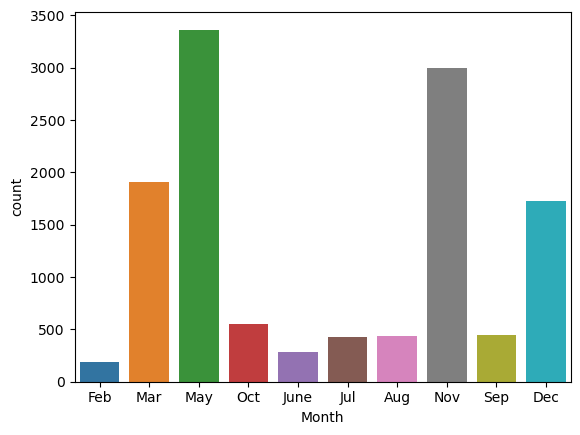

In [8]:
import seaborn as sns
sns.countplot(data  = df, x = 'Month')

<Axes: >

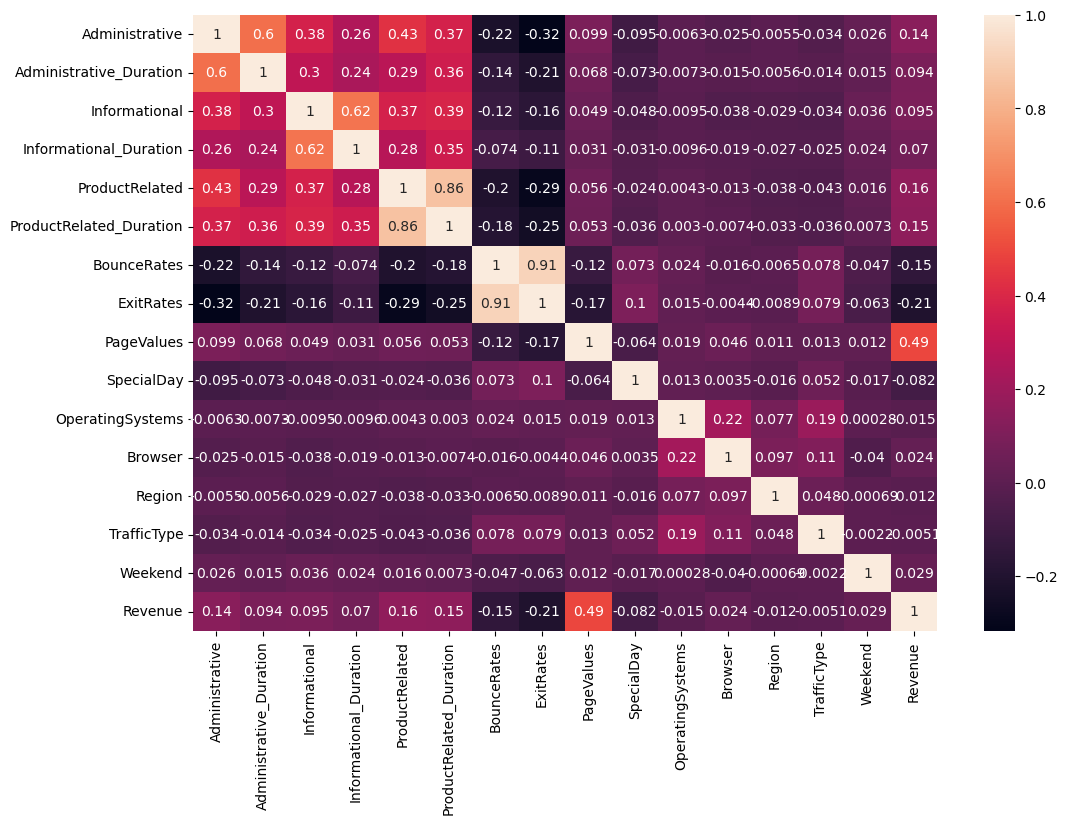

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True)
#cant really see much trends. Ill group by month and see if there is something here

## explain the administrative columns

- they represent the different types of webpages the visitor engages with and the amount of time spent. I am not sure how valuable this subset is

In [15]:
df.VisitorType.unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [360]:
#lets change the target variable to a numerial value

df['Revenue'] = df.Revenue.map({True: 1, False: 0})

In [350]:
#select target variable
target = 'Revenue'
X = df.drop(target, axis = 1)
y = df[target]

In [351]:
#because I have a pretty big dataset, ill check with .3 test size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=.3)

## Preprocessor

In [352]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#preprocess numerical columns
num_cols = X.select_dtypes('number').columns
num_trans = make_pipeline(StandardScaler())

#preprocessing for categorical columns
cat_cols = X.select_dtypes('object').columns
cat_trans = make_pipeline(OneHotEncoder(handle_unknown='error', drop='if_binary'))
#handle_unknown error raises an error if there is a very uncommon value that does not appear in training but in test
#sometimes is better to use = 'ignore' so the flow does not end

preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))


## Model selection

In [355]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV

models = [MLPClassifier(max_iter=1000), RandomForestClassifier(), GradientBoostingClassifier(), SVC(),
         LogisticRegression(max_iter=1000)]

for model in models:
    pipe = make_pipeline(preprocessor, model)
    grid = GridSearchCV(pipe, cv = 5, scoring = 'accuracy', param_grid = {})
    grid.fit(X_train, y_train)
    score = grid.best_score_
    print(f'Classifier: {model} score for accuracy: {round(score*100, 3)}%\n')

Classifier: MLPClassifier(max_iter=1000) score for accuracy: 87.997%

Classifier: RandomForestClassifier() score for accuracy: 90.557%

Classifier: GradientBoostingClassifier() score for accuracy: 90.488%

Classifier: SVC() score for accuracy: 89.376%

Classifier: LogisticRegression(max_iter=1000) score for accuracy: 88.449%



## Winners are GradientBoost  and RF
### Let's tune the hyperparams

In [312]:
param_grid_gr = {'gradientboostingclassifier__n_estimators': [100, 200, 300],
              'gradientboostingclassifier__learning_rate': [0.1, 0.2, 0.3, 1],
              'gradientboostingclassifier__loss': ['log_loss', 'exponential']}

pipe = make_pipeline(preprocessor, GradientBoostingClassifier())
grid_gr = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', cv = 5)

grid_gr.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Administrative', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         Index(['VisitorType'], dtype='object'))])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             param_grid={'gradientboostingclassifier__learning_rate': [0.1, 0.2,
                                                                       0.3, 1],
                         'gradientboostingclassifier__loss': ['log_loss',
                                                              'exponential'],
                         'gradientboostingclassifier__n_estimators': [100, 200,
                                                                      300]},
             scoring='accuracy')

In [313]:
print('best score:', grid_gr.best_score_)
print('best params:', grid_gr.best_params_)

best score: 0.9067324834054726
best params: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 200}


In [365]:
param_grid_rf = {'randomforestclassifier__min_samples_leaf': [1,2,4],
                 'randomforestclassifier__max_depth': [10, 15, None],
                 'randomforestclassifier__n_estimators': [100, 200, 300]} #more trees help better with overfitting

classifier = RandomForestClassifier(n_jobs= -1)
pipe = make_pipeline(preprocessor, classifier)

grid_rf = GridSearchCV(estimator=pipe, param_grid=param_grid_rf, cv = 5, scoring = 'accuracy')
grid_rf.fit(X_train, y_train)

print('best score: ', grid_rf.best_score_)
print('best params: ', grid_rf.best_params_)

best score:  0.9062691181769201
best params:  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 100}


In [315]:
param_grid_svc = {'svc__C': [0.1, 1, 2],
                  'svc__gamma': [00.1, 0.1, 1],
                  'svc__kernel': [ 'rbf', 'linear']} 

classifier = SVC()
pipe = make_pipeline(preprocessor, classifier)

grid_svc = GridSearchCV(estimator=pipe, param_grid=param_grid_svc, cv = 5, scoring = 'accuracy')
grid_svc.fit(X_train, y_train)

print('best score: ', grid_svc.best_score_)
print('best params: ', grid_svc.best_params_)

best score:  0.8995483765778471
best params:  {'svc__C': 2, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


## Final test on training data and testing data

Accuracy for Random Forest: 94.844
with parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 100}



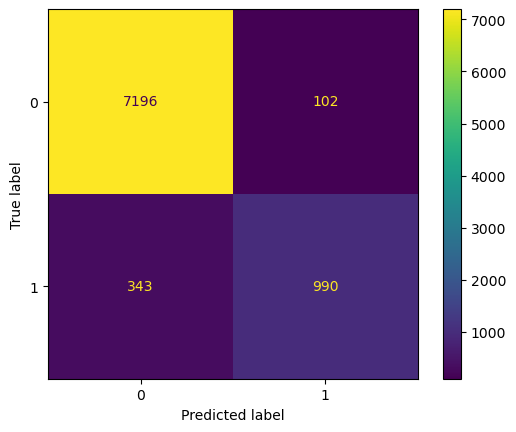

Accuracy for gradientboost: 92.133
with parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 200}



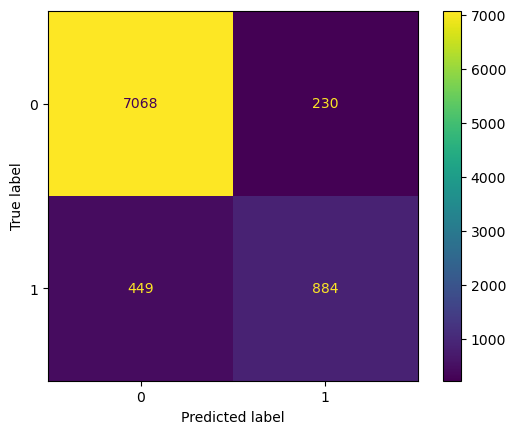

In [366]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

trained_models = {'Random Forest': grid_rf, 'gradientboost': grid_gr}

for name, model in trained_models.items():
    y_pred = model.predict(X_train)
    score = model.score(X_train, y_train)
    accuracy = accuracy_score(y_train, y_pred)
    params = model.best_params_
    
    print(f'Accuracy for {name}: {round(accuracy*100, 3)}')
    print(f'with parameters: {params}\n')
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train)
    plt.show()

## Test data

Accuracy for Random Forest: 0.8997026223303596
with parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 100}

0.5860869565217391
0.7170212765957447


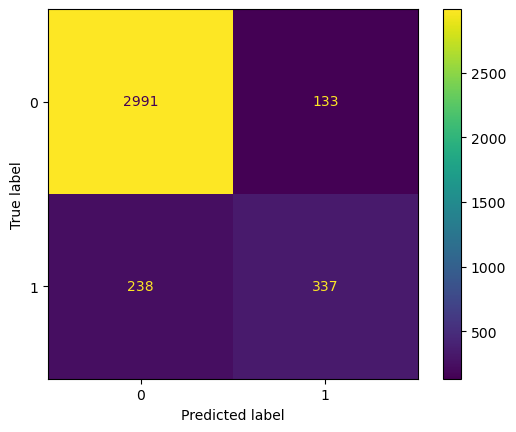

Accuracy for gradientboost: 0.8999729656663963
with parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 200}

0.6017391304347826
0.7104722792607803


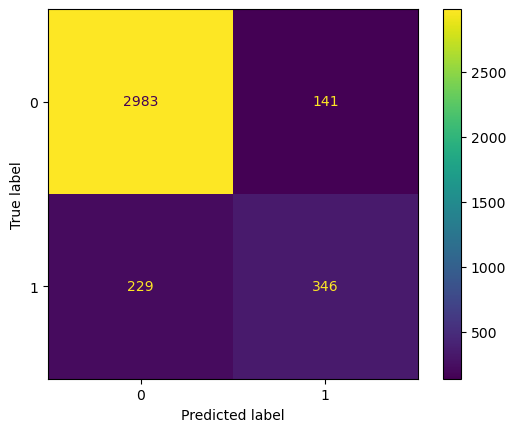

In [367]:
from sklearn.metrics import recall_score, precision_score
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    accuracy = accuracy_score(y_test, y_pred)
    params = model.best_params_
    rec_score = recall_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred)
    
    print(f'Accuracy for {name}: {accuracy}')
    print(f'with parameters: {params}\n')
    print(rec_score)
    print(prec_score)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()

### short analysis

- Gradient boost has better recall than random forest, but slightly less acc and worse precision.
Depending on what we are targeting, we could decide to choose for different models. We are predicting if a customer is going to spend money on the store with pretty good acc, but what errors do we care more of? is it indifferent?

- Having less false negatives means that we will improve recall. This are customers that we predict will not buy but actually buy something, so is really no loss.
- Instead, we should be fixing on the false positives! the model incorrectly misses someone as someone who will buy but really dont. Does it make sense to send them any type of incentive? or do we just want to go for the true positives?

#### I think as a conclusion that we should improve the accuracy, we want as many true positives as possible, the errors dont really matter here!

- So I will start some feature engineering! can we improve the acc of the model? I will start by studying the features that mattered for the model. First, from the predictions, lets see those customers. Then I will do some clustering. I will summarize whatever is interesting from this 2 things

In [44]:
#I have chosen the gradientboost one, since is the one that has more TP in both test and training data. I will re-train 
#for the whole dataset and then check the predictions

In [48]:
#grid_gr = grid_gr.best_estimator_
grid_gr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  Index(['Month', 'VisitorType'], dtype='object'))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(loss='exponential',
                                            n_estimators=200))])

In [50]:
predictions = grid_gr.predict(X)

In [52]:
#lets add it to the original df \
df['predictions'] = predictions

In [54]:
df_pred = df.loc[df.predictions == 1]

### After training a model and getting some metrics, I want to do some changes to the dataset, eliminating some columns, the ones that correlate less to the target variable and then compare if the acc is improved. In each point I summarize what I wanna do and what happened with the last run



In [334]:
import pandas as pd
df = pd.read_csv('online_shoppers_intention.csv')
df.columns


Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [206]:
target_correlation

Revenue                    1.000000
PageValues                 0.492569
ExitRates                  0.207071
ProductRelated             0.158538
Month_Nov                  0.154774
ProductRelated_Duration    0.152373
BounceRates                0.150673
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
SpecialDay                 0.082305
Month_May                  0.078320
Informational_Duration     0.070345
Month_Mar                  0.063941
Month_Feb                  0.047114
Month_Dec                  0.033112
Month_Oct                  0.032666
Weekend                    0.029295
Browser                    0.023984
Month_June                 0.023112
Month_Sep                  0.019983
OperatingSystems           0.014668
Region                     0.011595
TrafficType                0.005113
Month_Jul                  0.001036
Name: Revenue, dtype: float64

In [135]:
#df['time_spent'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
#df['n_pages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']

In [361]:
df = pd.get_dummies(data = df, columns = ['Month'], drop_first = True, dtype='int')

In [362]:
target = 'Revenue'
X = df.drop(columns = ['Revenue','OperatingSystems', 'Browser',  'TrafficType', 'Region', 'Weekend',
       'Administrative_Duration', 'Informational',
       'Informational_Duration','Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_June', 'Month_Mar', 'Month_May', 'Month_Oct',
       'Month_Sep', 'SpecialDay'])
y = df[target]

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=.3)

In [364]:
num_cols = X.select_dtypes('number').columns
num_trans = make_pipeline(StandardScaler())

#preprocessing for categorical columns
cat_cols = X.select_dtypes('object').columns
cat_trans = make_pipeline(OneHotEncoder(handle_unknown='error', drop='if_binary'))
#handle_unknown error raises an error if there is a very uncommon value that does not appear in training but in test
#sometimes is better to use = 'ignore' so the flow does not end

preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))

In [119]:
param_grid_gr = {'gradientboostingclassifier__n_estimators': [100, 200, 300],
              'gradientboostingclassifier__learning_rate': [0.1, 0.2, 0.3, 1],
              'gradientboostingclassifier__loss': ['log_loss', 'exponential']}

pipe = make_pipeline(preprocessor, GradientBoostingClassifier())
grid_gr = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', cv = 5)

grid_gr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Region',
       'time_spent', 'n_pages'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         Index(['VisitorType'], dtype='object'))])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             param_grid={'gradientboostingclassifier__learning_rate': [0.1, 0.2,
                                                                       0.3, 1],
                         'gradientboostingclassifier__loss': ['log_loss',
                                                              'exponential'],
                         'gradientboostingclassifier__n_estimators': [100, 200,
                                                                      300]},
             scoring='accuracy')

In [120]:
print('best score:', grid_gr.best_score_)
print('best params:', grid_gr.best_params_)

best score: 0.8980426073251427
best params: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 100}


Accuracy for gradientboost: 0.9097439462402966
with parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 100}



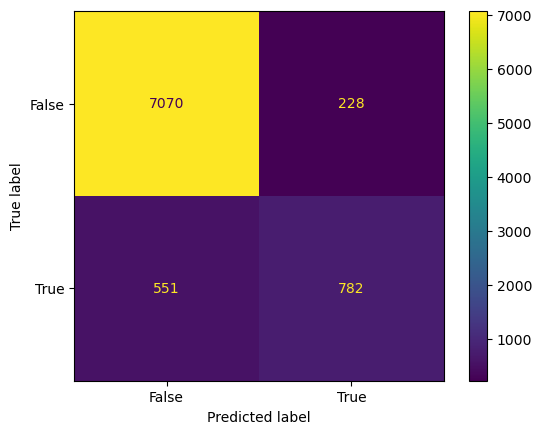

In [121]:
trained_models = {'gradientboost': grid_gr}

for name, model in trained_models.items():
    y_pred = model.predict(X_train)
    score = model.score(X_train, y_train)
    accuracy = accuracy_score(y_train, y_pred)
    params = model.best_params_
    
    print(f'Accuracy for {name}: {accuracy}')
    print(f'with parameters: {params}\n')
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train)
    plt.show()

Accuracy for gradientboost: 0.8924033522573669
with parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__n_estimators': 100}

0.5182608695652174
0.711217183770883


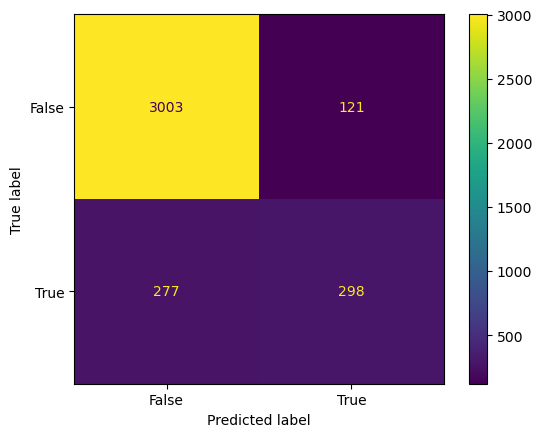

In [122]:
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    accuracy = accuracy_score(y_test, y_pred)
    params = model.best_params_
    rec_score = recall_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred)
    
    print(f'Accuracy for {name}: {accuracy}')
    print(f'with parameters: {params}\n')
    print(rec_score)
    print(prec_score)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()

### The changes in acc are almost 0 
- I  eliminated 'Revenue','OperatingSystems', 'Browser',  'TrafficType', 'Region', 'Weekend',
       'Administrative_Duration', 'Informational',
       'Informational_Duration','Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_June', 'Month_Mar', 'Month_May', 'Month_Oct',
       'Month_Sep', 'SpecialDay'
The month was splitted using dummy columns to see if there was a any special months. Only november turned out to be significant (black friday?)

- In the ensemble models from scikit learn, there is a VotingClassifier, that uses the output of several models to make the decision, using hard or soft voting between the models. You can add weights to the preferred model also. 
- Lets use it 

In [223]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1, max_iter=1000)
clf2 = RandomForestClassifier(random_state=1, n_jobs=-1)
clf3 = SVC()
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3), ],
    voting='hard'
)


pipe = make_pipeline(preprocessor, VotingClassifier(estimators=[('lr', clf1), ('rf', clf2),('svc', clf3),],
    voting='hard'))
pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Informational', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
       'Month_Nov'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  Index(['VisitorType'], dtype='object'))])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=1)),
                                              ('rf',
                                               RandomForestClassifier(n_jobs=-1,
                                                                      random_state=1)),
                                              ('svc', SVC())]))])

In [224]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Informational', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
       'Month_Nov'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  Index(['VisitorType'], dtype='object'))])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=1)),
                                              ('rf',
                                               RandomForestClassifier(n_jobs=-1,
                                                                      random_state=1)),
                                              ('svc', SVC())]))])

0.9194763063376202


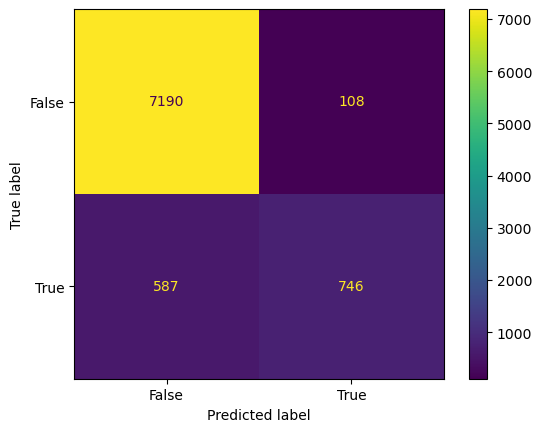

In [225]:
y_pred = pipe.predict(X_train)
ConfusionMatrixDisplay.from_estimator(pipe, X_train, y_train)
print(pipe.score(X_train, y_train))
plt.show()

Accuracy for votingClassifier: 0.8980805623141389
0.49043478260869566
0.7704918032786885


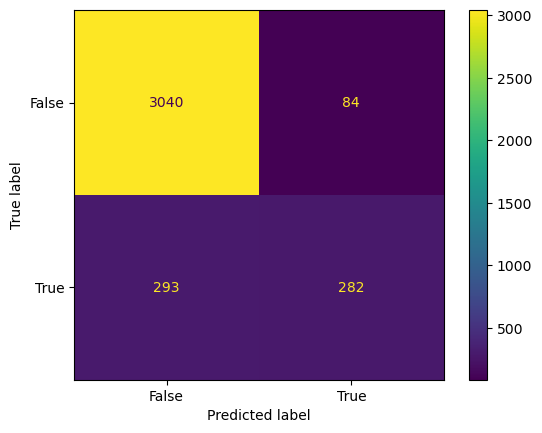

In [226]:
y_pred = pipe.predict(X_test)
score = pipe.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)

rec_score = recall_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred)

print(f'Accuracy for votingClassifier: {accuracy}')

print(rec_score)
print(prec_score)

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

In [348]:
X.columns

Index(['Administrative', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'VisitorType', 'Month_Nov'],
      dtype='object')

In [170]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
pipe = make_pipeline(preprocessor, model)
pipe.fit(X_train, y_train)

# Access feature importances
feature_importances = model.feature_importances_

In [171]:
feature_importances

array([0.05197081, 0.07292684, 0.02099747, 0.03379051, 0.08505024,
       0.11330203, 0.06913331, 0.10617414, 0.38633254, 0.00578826,
       0.03787636, 0.00820243, 0.00100358, 0.00745148])

In [172]:
X.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Region',
       'VisitorType', 'Weekend'],
      dtype='object')

In [174]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42)
feature_importances = result.importances_mean

In [175]:
feature_importances

array([ 0.00729927, -0.000784  , -0.00202758, -0.0010273 ,  0.00135172,
        0.00116248,  0.00027034,  0.00500135,  0.11959989,  0.00070289,
        0.00024331,  0.00048662,  0.        ])

In [203]:
correlation_matrix = df.corr(numeric_only=True)
target_correlation = correlation_matrix['Revenue'].abs().sort_values(ascending=False)

In [240]:
#lets re-run the votingclassifier and play with different settings
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


In [373]:
clf1 = LogisticRegression(random_state=1, max_iter=1000)
clf2 = RandomForestClassifier(random_state=1, n_jobs=-1)
clf3 = SVC(probability=True)
clf4 = MLPClassifier(max_iter=1000)
clf5 = KNeighborsClassifier()
eclf = VotingClassifier(
    estimators=[('lr', clf1),  ('svc', clf3), ('mlp', clf4)],
    voting='hard'
)


pipe = make_pipeline(preprocessor, eclf)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  Index(['VisitorType'], dtype='object'))])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=1)),
                                              ('svc', SVC(probability=True)),
                                              ('mlp',
                                               MLPClassifier(max_iter=1000))]))])

In [374]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  Index(['VisitorType'], dtype='object'))])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=1)),
                                              ('svc', SVC(probability=True)),
                                              ('mlp',
                                               MLPClassifier(max_iter=1000))]))])

In [370]:
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.9063839647781253
0.8975398756420654


In [281]:
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.9165797705943691
0.9005136523384698
